In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

print(os.getcwd())

g:\My Drive\1. EIT Digital master\Estland\Semester 1\Computer vision\its8030-2021-hw2


In [4]:
os.chdir("/Users/javiergalindos/OneDrive/OneDrive - Universidad Politécnica de Madrid/Documentos/MSc DM/2ºDM/Computer Vision/Code/its8030-2021-hw2")

(320, 249)


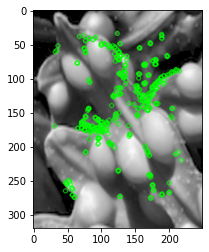

(<matplotlib.image.AxesImage at 0x1b01a3edfd0>, None)

In [2]:
### checking etalon features

img = cv2.imread('Etalons/Fucus/etalon_fucus_5.png',0)
print(img.shape)


# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints with ORB
kp = orb.detect(img,None)
# compute the descriptors with ORB
kp, des = orb.compute(img, kp)
# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

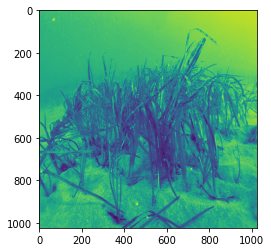

[['Fur' 'None' 'Fuc' 'None']
 ['Fuc' 'Fuc' 'FurZos' 'Zos']
 ['Fuc' 'Fur' 'Fur' 'Fuc']
 ['Fuc' 'FucFur' 'Fur' 'Fuc']]


In [12]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

# Read the query image as query_img
# and train image This query image
# is what you need to find in train image
# Save it in the same directory
# with the name image.jpg 


# PICK AN IMAGE 

#query_img_bw = cv2.imread('Etalons/Fucus/etalon_fucus_5.png',0)
#train_img_bw = cv2.imread('Processed images/Fucus/Fucus_24.jpg',0)
train_img_bw = cv2.imread('Processed images/Zostera marina/zostera_marina_26.jpg',0)
#train_img_bw = cv2.imread('Processed images/Furcellaria lumbricalis/furcellaria_lumbricalis_2.jpg',0)
#train_img_bw = cv2.imread('Processed images/Fucus/Fucus_7.jpg',0)

plt.imshow(train_img_bw),plt.show()
#print(train_img_bw.shape)
  
# Convert it to grayscale
# query_img_bw = cv2.cvtColor(query_img,cv2.COLOR_BGR2GRAY)
# train_img_bw = cv2.cvtColor(train_img, cv2.COLOR_BGR2GRAY)
  
# Initialize the ORB detector algorithm
orb = cv2.ORB_create()

######
# splitting the grid like a hacker
#
######
grid_per_side = 4
step = int(train_img_bw.shape[0]/grid_per_side) # 4x4 matrix

lowe_ratio = 0.6
good_match_thresh = 0
grid_class = np.empty(shape = (grid_per_side, grid_per_side), dtype='object')

classes = ['Fuc', 'Fur', 'Zos']


for x_coord in range(0, train_img_bw.shape[0], step):
    begin_x = x_coord
    end_x = x_coord + step
    for y_coord in range(0, train_img_bw.shape[1], step):
        begin_y = y_coord
        end_y = y_coord + step
        
        #step through every grid cell
        img_patch = train_img_bw[begin_x:end_x, begin_y:end_y]
        
        class_for_patch = []
        #now check this image patch with all the etalons, return the max class (or nothing) per img patch
        for folder in os.listdir('./Etalons'):
            #get to a particular class of etalon
            etalon_dir_path = os.path.join('./Etalons', folder)
            
            max_goodies = 0
            
            for etalon_img_path in os.listdir(etalon_dir_path):
                
                etalon_fullpath = os.path.join(etalon_dir_path, etalon_img_path)
                
                # Now detect the keypoints and compute
                # the descriptors for the query image
                # and train image
                query_img_bw = cv2.imread(etalon_fullpath,0)
                #print(etalon_fullpath)
                
                queryKeypoints, queryDescriptors = orb.detectAndCompute(query_img_bw,None)
                trainKeypoints, trainDescriptors = orb.detectAndCompute(img_patch,None)
                
                # Initialize the Matcher for matching
                # the keypoints and then match the
                # keypoints

                #matcher = cv2.DescriptorMatcher_create('BruteForce-L1') #BruteForce = L2, BruteForce-L1
                matcher = cv2.BFMatcher(cv2.NORMCONV_FILTER)
                matches = matcher.knnMatch(queryDescriptors,trainDescriptors, k=2)
                
                # draw the matches to the final image
                # containing both the images the drawMatches()
                # function takes both images and keypoints
                # and outputs the matched query image with
                # its train image
                # final_img = cv2.drawMatchesKnn(query_img_bw, queryKeypoints,
                # img_patch, trainKeypoints, matches[:50],None)
                good = [[m] for m, n in matches if m.distance < lowe_ratio*n.distance]
                # img3 = cv2.drawMatchesKnn(query_img_bw,queryKeypoints,img_patch,trainKeypoints,good, None, flags=2)
                max_goodies += len(good)

            class_for_patch.append(max_goodies)
        #print((class_for_patch))
        if np.max(class_for_patch) > good_match_thresh:
            #deal with multiple maxima at one point
            m = [i for i,j in enumerate(class_for_patch) if j==np.max(class_for_patch)]
           
            pred_patch_class = ''
            for i in m:
                pred_patch_class += classes[i]

        else:
            pred_patch_class = 'None'
            
        #print(pred_patch_class)
        grid_class[int(begin_x/step),int(begin_y/step)] = pred_patch_class

print(grid_class)
        
        

In [13]:
print(grid_class)

len_per_class = 3
grid_vect = np.zeros(16, dtype='object')
nr = 0
numerical_grid = np.zeros((grid_per_side, grid_per_side), dtype='float')
for i in range(grid_per_side):
    for j in range(grid_per_side):
        #numerical_grid[i][j] = round(len_per_class/len(grid_class[i][j]),2)
        numerical_grid[i][j] = nr
        grid_vect[nr] = grid_class[i][j]
        
        nr +=1
print(numerical_grid)

[['Fur' 'None' 'Fuc' 'None']
 ['Fuc' 'Fuc' 'FurZos' 'Zos']
 ['Fuc' 'Fur' 'Fur' 'Fuc']
 ['Fuc' 'FucFur' 'Fur' 'Fuc']]
[[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]
 [12. 13. 14. 15.]]


In [14]:
import re

grid_vect

classes = ['Fuc', 'Fur', 'Zos', 'None']

box10 = [0,1,4,5]
box11 = [1,2,5,6]
box12 = [2,3,6,7]

box20 = [4,5,8,9]
box21 = [5,6,9,10]
box22 = [6,7,10,11]

box30 = [8,9,12,13]
box31 = [9,10,13,14]
box32 = [10,11,14,15]

all_windows = [box10, box11, box12, box20, box21, box22, box30, box31,box32]
windows_names = ['box10', 'box11', 'box12', 'box20', 'box21', 'box22', 'box30', 'box31','box32']
i = 0
best_class = np.zeros(9, dtype='object')
best_class_num = np.zeros(9, dtype='int')
best_class_conf = np.zeros(9, dtype='float')

for box in all_windows:

    fuc = 0
    fur = 0
    zos = 0
    no = 0
    for element in grid_vect[box]:
        #if the are multiple elements, we give it a lower score per class
        #because we don't award confusion :)
        if(len(element) == 9):
            multiplier = (1/3)
        elif(len(element) == 6):
            multiplier = (1/2)
        else:
            multiplier = 1
        fuc += multiplier*len(re.findall('Fuc', element))
        fur += multiplier*len(re.findall('Fur', element))
        zos += multiplier*len(re.findall('Zos', element))
        no += multiplier*len(re.findall('None', element))
    

    # print(fuc)
    # print(fur)
    # print(zos)
    # print(no)
    #find all the occurences of maximum class
    m = [skd for skd,j in enumerate((fuc, fur, zos, no)) if j==np.max((fuc, fur, zos, no))]
    #more than 2 with same likelihood? then just None to avoid confusion
    #print(m)
    if(len(m) > 1):
        best_class[i] = classes[3] #none
        best_class_num[i] = 3
    else:
        best_class[i] = classes[np.argmax((fuc, fur, zos, no))]
        best_class_num[i] = np.argmax((fuc, fur, zos, no))
    
    best_class_conf[i] = np.round((np.max((fuc, fur, zos, no))/4), 4)
    
    print('%s: %s' %(windows_names[i], best_class[i]))
    i+=1

box10: Fuc
box11: Fuc
box12: Zos
box20: Fuc
box21: Fur
box22: None
box30: Fuc
box31: Fur
box32: None


In [15]:
best_class = best_class.reshape((3,3))
best_class_num = best_class_num.reshape((3,3))
best_class_conf = best_class_conf.reshape((3,3))
print(best_class)
print(best_class_num)
print(best_class_conf)

[['Fuc' 'Fuc' 'Zos']
 ['Fuc' 'Fur' 'None']
 ['Fuc' 'Fur' 'None']]
[[0 0 2]
 [0 1 3]
 [0 1 3]]
[[0.5   0.5   0.375]
 [0.75  0.625 0.375]
 [0.625 0.875 0.5  ]]


## Filling up neighbouring patches

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, color, morphology
from skimage.segmentation import flood, flood_fill

all_indeces = [(0,0), (0,1), (0,2), (1, 0), (1, 1), (1, 2), (2, 0), (2,1), (2, 2)]
coordinates = np.zeros((3,3), dtype = 'int')

for index in all_indeces:
    #get the value of the index
    x = index[0]
    y = index[1]
    if best_class_num[x][y] >= 0:
        #map to specific class, -1 is fucus, -2 is furcellaria, -3 is Zos and otherwise its None
        value = (-1 if best_class_num[x][y] == 0 else -2 if best_class_num[x][y] == 1 else -3 if best_class_num[x][y] == 2 else -4)
        #filled_checkers = flood_fill(best_class_num, index, value)
        findconn = flood(best_class_num, index)
       
        
        if(np.sum(findconn)) > 1:
            where_is_it = np.where(findconn == True)
            for i in range(len(where_is_it[0])):
                o = where_is_it[0][i]
                u = where_is_it[1][i]
                coordinates[o][u] = value
            
            
print(coordinates)
        

[[-1 -1  0]
 [-1 -2 -4]
 [-1 -2 -4]]


In [22]:
from skimage.measure import label, regionprops

def fill_bounding_boxes(x):
    l = label(x)
    print(l)
    # print(l)
    # print(regionprops(l))
    for s in regionprops(l):
        print(s.slice)
        x[s.slice] = -1
    return x

res = fill_bounding_boxes(coordinates)
print(res)

[[1 1 0]
 [1 2 3]
 [1 2 3]]
(slice(0, 3, None), slice(0, 2, None))
(slice(1, 3, None), slice(1, 2, None))
(slice(1, 3, None), slice(2, 3, None))
[[-1 -1  0]
 [-1 -1 -1]
 [-1 -1 -1]]


## Draw the bounding boxes

In [11]:
# image = cv2.imread('Processed images/Zostera marina/zostera_marina_26.jpg')

# step = 256*(4/3)

# for i in range(-3,0):
#     where_is_it = np.where(coordinates == i)
#     if len(where_is_it[0]) > 0:
#         o = where_is_it[0]
#         u = where_is_it[1]
        
#         # print(o)
#         # print(u)
        
#         # start_point = (o[0]*step,u[0]*step)
#         # end_point = (o[-1]*step, (u[-1]*step + step))
        
        
#         start_point = (u[0]*step,o[0]*step)
#         end_point = (u[-1]*step + step,o[-1]*step + step)
        
#         # print((o[0], u[0]))
#         # print((o[-1], u[-1]))
        
#         print(start_point)
#         print(end_point)
        
#         length_x = abs(o[0] - (o[-1]))
#         length_y = abs((u[0] - u[-1]))

#         print(length_x/length_y)
        
#         # print(diffx)
#         # print(diffy)
        
#         # if diffx == 0.0 and diffy != 0.0:
#         #     end_point = (o[-1]*step + diffy, u[-1]*step)
        
#         # if diffy == 0.0 and diffx != 0.0:
#         #     end_point = (o[-1]*step, u[-1]*step + diffx)
        
#         # if diffx == 0.0 and diffy != 0.0:
#         #     end_point = (u[-1]*step + step,o[-1]*step + step)
        
#         # if diffy == 0.0 and diffx != 0.0:
#         #     end_point = (u[-1]*step + step + diffx,o[-1]*step + step)
        
#         #fuc fur zos, none doesnt get plotted
#         color_list = [[0,0,255], [0,255,0], [255,0,0]]
#         class_name = ['Fucus', 'Furcellaria', 'Zostera']
#         class_single = class_name[(-i-1)]
#         color = color_list[(-i-1)]
#         thickness = 2
#         # print(int(start_point))
#         # print(int(end_point))
        
#         # print((int(start_point[0]), int(start_point[1])))
#         # print((int(end_point[0]), int(end_point[1])))
#         image = cv2.rectangle(image, (int(start_point[0]), int(start_point[1])), (int(end_point[0]), int(end_point[1])), color, thickness)
#         image = cv2.putText(image, class_single, (int(start_point[0]+5), int(start_point[1])+30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# cv2.imshow('Rectangle',image)
# cv2.waitKey(0)

(0.0, 0.0)
(1024.0, 682.6666666666666)
1.0


-1

In [7]:
image = cv2.cvtColor(train_img_bw, cv2.COLOR_GRAY2BGR)

step = 256*(4/3)
pred = []

for j in range(grid_per_side-1):
    for i in range(grid_per_side-1):
        value = coordinates[j][i]
        
        if value in [-3, -2, -1]:
            color_list = [[0,0,255], [0,255,0], [255,0,0]]
            class_name = ['Fucus', 'Furcellaria', 'Zostera']
            class_single = class_name[(-value-1)]
            color = color_list[(-value-1)]
            thickness = 2
            # print(int(start_point))
            # print(int(end_point))
            
            # print((int(start_point[0]), int(start_point[1])))
            # print((int(end_point[0]), int(end_point[1])))
            outputstr = class_single + ': ' + str(best_class_conf[i][j])
            
            image = cv2.rectangle(image, (int(i*step), int(j*step)), (int(i*step + step), int(j*step+step)), color, thickness)
            
            pred.append([float(int(i*step)), float(int(j*step)), float(int(i*step + step)), float(int(j*step+step)), class_single, best_class_conf[i][j]])
            
            image = cv2.putText(image, outputstr, ((int(i*step)+5), int(j*step)+30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)




pred = np.array(pred)        
cv2.imshow('Rectangle',image)
cv2.waitKey(0)        

-1

In [9]:
unique_classes = np.unique(pred[:,4])
print(unique_classes)


['Fucus']


## Get ground-truth from XML

In [8]:
from bs4 import BeautifulSoup
 
 
# Reading the data inside the xml
# file to a variable under the name
# data
with open('./Processed images/FucusLabels.xml', 'r') as f:
    data = f.read()
 
# Passing the stored data inside
# the beautifulsoup parser, storing
# the returned object
Bs_data = BeautifulSoup(data, "xml")
 
# Finding all instances of tag
# `unique`
b_unique = Bs_data.find_all('image')

#print(b_unique)
 
# Using find() to extract attributes
# of the first instance of the tag
b_name = Bs_data.find('image',{'name':'fucus_7.jpg'})

box_data = b_name.find('box')
xbr = int(float(box_data.get('xbr')))
xtl = int(float(box_data.get('xtl')))
ybr = int(float(box_data.get('ybr')))
ytl = int(float(box_data.get('ytl')))
label = box_data.get('label')

#https://pypi.org/project/mean-average-precision/
gt = np.array([xtl, ytl, xbr, ybr, 0.0, 0.0, 0.0], dtype=int) #idk about the 0,0 with 
 
print(b_name)
print(xbr)
# Extracting the data stored in a
# specific attribute of the
# `child` tag
# value = b_name.get('test')
 
# print(value)

<image height="1024" id="52" name="fucus_7.jpg" width="1024">
<box label="Fucus" occluded="0" source="manual" xbr="798.52" xtl="161.66" ybr="950.19" ytl="204.40" z_order="0">
</box>
</image>
798


In [9]:
#pred = np.array([np.min(pred[:,0]), np.min(pred[:,1]), np.max(pred[:,2]), np.max(pred[:,3]), 0, np.mean(pred[:,5])])
print(pred)

[[0.000e+00 0.000e+00 3.410e+02 3.410e+02 0.000e+00 7.500e-01]
 [3.410e+02 0.000e+00 6.820e+02 3.410e+02 0.000e+00 8.750e-01]
 [0.000e+00 3.410e+02 3.410e+02 6.820e+02 0.000e+00 7.500e-01]
 [3.410e+02 3.410e+02 6.820e+02 6.820e+02 0.000e+00 7.500e-01]
 [0.000e+00 6.820e+02 3.410e+02 1.024e+03 0.000e+00 3.333e-01]
 [3.410e+02 6.820e+02 6.820e+02 1.024e+03 0.000e+00 5.833e-01]
 [6.820e+02 6.820e+02 1.024e+03 1.024e+03 0.000e+00 5.000e-01]]


In [35]:
print(gt)

[161 204 798 950   0   0   0]


In [52]:
canvas = np.ones((2000, 2000, 3), dtype="uint8")

image = cv2.rectangle(canvas, (int(pred[3][0]), int(pred[3][1])), (int(pred[3][2]), int(pred[3][3])), color = [255,0,0], thickness = 2)
image = cv2.rectangle(image, (int(gt[0]), int(gt[1])), (int(gt[2]), int(gt[3])), color = [0,255,0], thickness = 2)

cv2.imshow('drawing',image)
cv2.waitKey(0)

-1

In [49]:
pred[0][0]

0.0

### Calculate MAP

In [29]:
from mean_average_precision import MetricBuilder

# # [xmin, ymin, xmax, ymax, class_id, difficult, crowd]
# gt = np.array([
#     [439, 157, 556, 241, 0, 0, 0],
#     [437, 246, 518, 351, 0, 0, 0],
#     [515, 306, 595, 375, 0, 0, 0],
#     [407, 386, 531, 476, 0, 0, 0],
#     [544, 419, 621, 476, 0, 0, 0],
#     [609, 297, 636, 392, 0, 0, 0]
# ])

# # [xmin, ymin, xmax, ymax, class_id, confidence]
# preds = np.array([
#     [429, 219, 528, 247, 0, 0.460851],
#     [433, 260, 506, 336, 0, 0.269833],
#     [518, 314, 603, 369, 0, 0.462608],
#     [592, 310, 634, 388, 0, 0.298196],
#     [403, 384, 517, 461, 0, 0.382881],
#     [405, 429, 519, 470, 0, 0.369369],
#     [433, 272, 499, 341, 0, 0.272826],
#     [413, 390, 515, 459, 0, 0.619459]
# ])

# print list of available metrics
print(MetricBuilder.get_metrics_list())

# create metric_fn
metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=1)

# add some samples to evaluation
for _ in range(10):
    metric_fn.add(pred, gt)


['map_2d']


In [34]:
# compute PASCAL VOC metric
print(f"VOC PASCAL mAP: {metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']}")

# compute PASCAL VOC metric at the all points
print(f"VOC PASCAL mAP in all points: {metric_fn.value(iou_thresholds=0.1)['mAP']}")

# compute metric COCO metric
print(f"COCO mAP: {metric_fn.value(iou_thresholds=np.arange(0.01, 0.11, 0.01), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']}")

VOC PASCAL mAP: 0.0
VOC PASCAL mAP in all points: 0.0
COCO mAP: 0.0


# ---------

In [11]:
### Getting a score


# This time, we will use BFMatcher.knnMatch() to get k best matches. 
# In this example, we will take k=2 so that we can apply ratio test 
# explained by D.Lowe in his paper. 

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

os.chdir("g:\\My Drive\\1. EIT Digital master\\Estland\\Semester 1\\Computer vision\\its8030-2021-hw2\\")

def FDBaseline(classtype_etalon = 'Fucus', classtype_train = 'Fucus', lowe_ratio = 0.7, method = 'ORB'):
    thresh_good = 2 
    
    etalon_dir_path = './etalons/'
    process_img_path = './Processed images/'

    etalon_dir_path = os.path.join(etalon_dir_path, classtype_etalon)
    process_img_path = os.path.join(process_img_path, classtype_train)

    results = np.zeros(shape=(len(os.listdir(process_img_path)), len(os.listdir(etalon_dir_path))))

    row = 0
    for img_path in os.listdir(process_img_path):
        
        folder_path_img= os.path.join(process_img_path, img_path)
        img = cv2.imread(folder_path_img,0)

        col = 0
        for etalon_path in os.listdir(etalon_dir_path):
            
            etalon_path_img= os.path.join(etalon_dir_path, etalon_path)
            etalon = cv2.imread(etalon_path_img,0)

            good = []
            
            if method == 'ORB':
                finder = cv2.ORB_create()
                # find the keypoints and descriptors with ORB
                kp1, des1 = finder.detectAndCompute(etalon,None)
                kp2, des2 = finder.detectAndCompute(img,None)
                
                # BFMatcher with hamming >> L2
                bf = cv2.BFMatcher(cv2.NORM_HAMMING)
                matches = bf.knnMatch(des1,des2, k=2)
                # Apply ratio test
                good = [[m] for m, n in matches if m.distance < lowe_ratio*n.distance]
                if len(good) > thresh_good:
                    #img3 = cv2.drawMatchesKnn(etalon,kp1,img,kp2,good, None, flags=2)
                    #fname = 'output_%s_%s_.png' % (img_path, etalon_path)
                    #cv2.imwrite(fname, img3)
                    # font = cv2.FONT_HERSHEY_SIMPLEX
                    results[row][col] = len(good)

            if method == 'SIFT':
                # Initiate SIFT detector
                sift = cv2.SIFT_create()
                # find the keypoints and descriptors with SIFT
                kp1, des1 = sift.detectAndCompute(etalon,None)
                kp2, des2 = sift.detectAndCompute(img,None)
                
                length = 0
                
                # FLANN parameters
                FLANN_INDEX_KDTREE = 1
                index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
                search_params = dict(checks=50)   # or pass empty dictionary
                flann = cv2.FlannBasedMatcher(index_params,search_params)
                matches = flann.knnMatch(des1,des2,k=2)
                # Need to draw only good matches, so create a mask

                good = []
                # ratio test as per Lowe's paper
                for m,n in (matches):
                    if m.distance <lowe_ratio*n.distance:
                        good.append(m)
                
                if len(good) > thresh_good:
                    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
                    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

                    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
                    matchesMask = mask.ravel().tolist()

                    h,w = etalon.shape
                    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
                    dst = cv2.perspectiveTransform(pts,M)

                    img = cv2.polylines(img,[np.int32(dst)],True,255,3, cv2.LINE_AA)
                    draw_params = dict(matchColor = (0,255,0),
                                        singlePointColor = (255,0,0),
                                        matchesMask = matchesMask,
                                        flags = cv2.DrawMatchesFlags_DEFAULT)
                    fname = 'output_%s_%s_.png' % (img_path, etalon_path)
                    img3 = cv2.drawMatches(etalon,kp1,img,kp2,good,None,**draw_params)   
                    cv2.imwrite(fname, img3)
                    # font = cv2.FONT_HERSHEY_SIMPLEX
                    results[row][col] = length



            # msg1 = 'using %s with lowe_ratio %.2f' % (method, lowe_ratio)
            # msg2 = 'there are %d good matches' % (len(good))


            # print(msg1)
            # print(msg2)
            # cv2.putText(img3,msg1,(10, 250), font, 0.5,(255,255,255),1,cv2.LINE_AA)
            # cv2.putText(img3,msg2,(10, 270), font, 0.5,(255,255,255),1,cv2.LINE_AA)


            col += 1
            #plt.imshow(img3),plt.show()
        row += 1
    return results

In [12]:
results = FDBaseline(classtype_etalon = 'Fucus', classtype_train = 'Fucus', lowe_ratio = 0.7, method = 'SIFT')
print(np.amax(results,1))
print(np.mean(np.amax(results,1)))

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-sn_xpupm\opencv\modules\core\src\matmul.dispatch.cpp:531: error: (-215:Assertion failed) scn + 1 == m.cols in function 'cv::perspectiveTransform'


In [4]:
results

array([[  7.,   0.,   0.],
       [695.,   0.,   0.],
       [ 10.,   0., 517.],
       [  6.,   7.,   0.],
       [  7.,   0.,   0.],
       [  4.,   0.,   3.],
       [  5.,   0.,   6.],
       [  0.,   0.,   0.],
       [  5.,   0.,   0.],
       [  0.,   0.,   0.],
       [  4.,   0.,   3.],
       [  4.,   0.,   0.],
       [  5.,   0.,   0.],
       [  5.,   0.,   0.],
       [  6.,   0.,   4.],
       [  6.,   0.,   4.],
       [  3.,   0.,   3.],
       [  3.,   0.,   0.],
       [  6.,   0.,   4.],
       [  0.,   0.,   0.],
       [  0.,   0.,   5.],
       [  0.,   0.,   4.],
       [  0.,   0.,   0.],
       [  7.,   0.,   0.],
       [  5.,   0.,   0.],
       [  0.,   0.,   0.],
       [  7.,   0.,   3.],
       [  5.,   0.,   4.],
       [  9.,   0.,   0.],
       [  4.,   0.,   0.],
       [ 10.,   0.,   7.],
       [  0.,   0.,   3.],
       [  9.,   0.,   4.],
       [  4.,   0.,   0.],
       [  9.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   3.,   3.],
 

In [5]:
#how many good classifications do we consider to be good?
our_threshold = 2

max_vals = (np.amax(results,1))
good_classifc = np.count_nonzero((max_vals > our_threshold))

ratio = round(good_classifc / results.shape[0],2)
ratio

0.85

In [67]:
def FDpredict(img_select = './Processed images/Fucus/Fucus_0.jpg', lowe_ratio = 0.7, method = 'ORB' ):
    etalon_dir_path = './Etalons/'
    im_results = np.zeros(shape=(1,10)) #10 because we dont know the exact amount of etalons
    final_results = np.zeros(shape=(1,3))

    img = cv2.imread(img_select,0)
    
    col_final = 0
    for etalon_folder in os.listdir(etalon_dir_path):
        col_im = 0

        class_etalon = os.path.join(etalon_dir_path, etalon_folder)
        
        for etalon_path in os.listdir(class_etalon):
            
            etalon_path_img= os.path.join(class_etalon, etalon_path)
            etalon = cv2.imread(etalon_path_img,0)


            if method == 'ORB':
                finder = cv2.ORB_create()

            # find the keypoints and descriptors with SIFT
            kp1, des1 = finder.detectAndCompute(etalon,None)
            kp2, des2 = finder.detectAndCompute(img,None)

            # BFMatcher with default params
            bf = cv2.BFMatcher()
            matches = bf.knnMatch(des1,des2, k=2)

            # Apply ratio test
            good = []

            good = [[m] for m, n in matches if m.distance < lowe_ratio*n.distance]

            # msg1 = 'using %s with lowe_ratio %.2f' % (method, lowe_ratio)
            # msg2 = 'there are %d good matches' % (len(good))

            # img3 = cv2.drawMatchesKnn(etalon,kp1,img,kp2,good, None, flags=2)

            # font = cv2.FONT_HERSHEY_SIMPLEX

            im_results[0][col_im] = len(good)
            # print(msg1)
            # print(msg2)
            # cv2.putText(img3,msg1,(10, 250), font, 0.5,(255,255,255),1,cv2.LINE_AA)
            # cv2.putText(img3,msg2,(10, 270), font, 0.5,(255,255,255),1,cv2.LINE_AA)
            # fname = 'output_%s_%.2f.png' % (method, lowe_ratio)
            # cv2.imwrite(fname, img3)
            col_im += 1
            #plt.imshow(img3),plt.show()
        final_results[0][col_final] = np.sum(im_results)/len(os.listdir(etalon_dir_path)) #get average so that it is not biased with number of etalons
        col_final += 1
    return final_results

In [70]:
os.chdir("g:\\My Drive\\1. EIT Digital master\\Estland\\Semester 1\\Computer vision\\its8030-2021-hw2\\")


img = './Processed images/Fucus/Fucus_13.jpg'
results = FDpredict(img_select = img, lowe_ratio = 0.7, method = 'ORB' )
print(results)

if(np.argmax(results) == 0):
    print('Predicted %s as: Fucus' %img )


elif(np.argmax(results) == 1):
    print('Predicted %s as: Furcellaria lumbricalis' %img )

else:
    print('Predicted %s as: Zostera marina' %img )

[[1.         1.33333333 1.        ]]
Predicted ./Processed images/Fucus/Fucus_13.jpg as: Furcellaria lumbricalis


In [10]:
results = FDBaseline(classtype_etalon = 'Fucus', classtype_train = 'Fucus', lowe_ratio = 0.7, method = 'SIFT')
print(np.amax(results,1))
print(np.mean(np.amax(results,1)))

[  6. 694. 517.   8.   7.   4.   6.   4.   5.   0.   4.   0.   4.   0.
   8.   8.   3.   0.   6.   0.   8.   4.   3.   5.   3.   0.   7.   4.
   7.   5.  10.   4.   9.   3.   9.   0.   3.   3.   3.   9.   5.   5.
 227.   6.   3.   5.   0.   6.   3.   3.   6.   5.   6.   5.   5.]
30.418181818181818


In [12]:
results = FDBaseline(classtype_etalon = 'Fucus', classtype_train = 'Furcellaria lumbricalis', lowe_ratio = 0.7, method = 'SIFT')
print(np.amax(results,1))
print(np.mean(np.amax(results,1)))

[0. 5. 4. 6. 0. 3. 3. 3. 6. 0. 4. 4. 6. 5. 4. 3. 4. 3. 0. 0. 7. 0. 4. 3.
 8. 5. 3. 5. 4. 3. 0. 5. 5. 3. 0. 5. 6. 3. 3. 4. 3. 0. 8. 4.]
3.5


In [9]:
results = FDBaseline(classtype_etalon = 'Fucus', classtype_train = 'Zostera marina', lowe_ratio = 0.7, method = 'SIFT')
print(np.amax(results,1))
print(np.mean(np.amax(results,1)))

[ 5.  4.  0.  6.  3.  5.  5.  0.  0.  5.  3.  4.  5.  3.  7.  4.  0.  0.
  4.  3.  7.  3.  5.  0.  3.  3.  0.  3.  3.  0.  3.  0.  4.  0.  3.  0.
  6.  3.  5.  3.  4.  5.  4.  5.  4. 12.  3.  3.  0.]
3.2653061224489797
